In [55]:
!pip install -U kaleido

In [56]:
"""Create Plots and save them in folder data/plot_images."""

# local functions
from utils.sdg_description import  sdg_short_description, sdg_colors, class_names
from training.text.base_model.utils.text_processing import text_preprocessing

# basics
import pandas as pd
import numpy as np
import json
import os

# metrics
from sklearn.metrics import precision_recall_fscore_support, classification_report, f1_score

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pandas.plotting import table
import seaborn as sns
from wordcloud import WordCloud


model_name_dict = {'glove_svm': 'GloVe SVM', 'word2vec_svm': 'Word2Vec SVM', 'roberta': 'RoBERTa', 'bert': 'BERT', 'xlnet': 'XLNet', 'gpt2': 'GPT-2'}

In [57]:
# Load Data

# training set I
text_train_1 = pd.read_csv("data/text_train_1.csv")

# training set II
text_train_2 = pd.read_csv("data/text_train_2.csv")

# testing set
text_test = pd.read_csv("data/text_test.csv")

# validation set
text_val = pd.read_csv("data/text_val.csv")

# SR data
sr_data = pd.read_csv("data/sr_data_clean.csv")

# Image Training History
with open('data/histories/image_history.json') as f:
    image_histories = json.load(f)

# Transformer Training Histories
transformer_histories = {}
for model in ['1_bert', '2_bert', '2_roberta', '2_xlnet', '2_gpt2']:
    with open(f'data/histories/{model}.json') as f:
        history = json.load(f)[model]
        transformer_histories[model] = history

# SVM Training Histories
with open('data/histories/base_model_histories.json') as f:
    svm_histories = json.load(f)

In [58]:
# Scientific Data: Distribution of samples per class

# prepare
sgd_value_counts = text_train_1[text_train_1['data_origin'] != 'wikipedia article'].groupby(['sdg', 'data_origin'])['text'].count().to_frame()
sgd_value_counts.reset_index(inplace=True)
sgd_value_counts['sdg'] = sgd_value_counts['sdg'].apply(lambda x: str(x))

# plot
fig = px.bar(
    sgd_value_counts, 
    x='sdg', 
    y='text', 
    color='data_origin',
    color_discrete_map={
        'paper abstract': 'gray',
        'un website': "#9e9e9e"
    }
).update_layout(
    xaxis_title="SDG", 
    yaxis_title="Frequency", 
    legend_title="Data Origin", 
    xaxis_tickmode='linear',
    # legend=dict(
    #     yanchor="top",
    #     y=1.0,
    #     xanchor="left",
    #     x=0.01
    # ),
    legend_traceorder="reversed"
)
pio.write_image(fig, "data/plot_images/frequency_si_data.png", scale=3, width=900, height=400)
fig.show()

In [59]:

# # plot image classification history
# def plot_f1(history):
#     df = pd.DataFrame({'f1': history['val_f1'], 'epoch': range(1,len(history['val_f1'])+1)})
#     fig = px.line(df, x='epoch', y='f1', width=400, height=400).update_layout(
#         xaxis_title="Epoch", yaxis_title="F1"
#     )
#     fig.show()

# def plot_loss(history):
#     df = pd.DataFrame({'train_loss': history['train_loss'], 'val_loss': history['val_loss'], 'epoch': range(1,len(history['val_f1'])+1)})
#     fig = px.line(df, x='epoch', y=['train_loss', 'val_loss'], width=400, height=400).update_layout(
#         xaxis_title="Epoch", yaxis_title="Loss"
#     )
#     fig.show()

In [60]:
# SR Data: # positive labels per sample

# prepare
# calcualte # per sample
sr_data['count_sdgs'] = sr_data[class_names].sum(axis=1)

# aggreagte # per sample
sgd_value_counts = sr_data.groupby('count_sdgs')['text'].count().to_frame()

# beautify
sgd_value_counts['sdg'] = sgd_value_counts.index
sgd_value_counts['sdg'] = sgd_value_counts['sdg'].apply(lambda x: str(int(x)))
sgd_value_counts['color'] =  "#9e9e9e"

# plot
fig = px.bar(sgd_value_counts, 
    x='sdg', 
    y='text', 
    color_discrete_sequence = list(sgd_value_counts['color'])
).update_layout(
    xaxis_title="Amount SDGs", 
    yaxis_title="Count Pages",
    xaxis_tickmode='linear',
)
pio.write_image(fig, "data/plot_images/labels_per_sample.png", scale=3, width=900, height=400)
fig.show()

# additionly print mean count and sum to write it into text
print('mean: ',sr_data['count_sdgs'].mean() )
print(sgd_value_counts)
print('sum: ', sgd_value_counts['text'].sum())

mean:  3.106463878326996
            text sdg    color
count_sdgs                   
1.0          312   1  #9e9e9e
2.0          236   2  #9e9e9e
3.0          127   3  #9e9e9e
4.0          144   4  #9e9e9e
5.0           72   5  #9e9e9e
6.0           65   6  #9e9e9e
7.0           33   7  #9e9e9e
8.0           37   8  #9e9e9e
9.0           12   9  #9e9e9e
10.0          12  10  #9e9e9e
11.0           2  11  #9e9e9e
sum:  1052


In [61]:
# SR data: distribution of # words per sample

# prepare
sr_data['text_length'] = sr_data['text'].apply(lambda x: len(str(x).split()))

# plot
fig = px.histogram(
    sr_data, 
    x='text_length',
    color_discrete_sequence=["#9e9e9e"]
).update_layout(
    xaxis_title="Text Length", 
    yaxis_title="Samples",
)
pio.write_image(fig, "data/plot_images/hist_text_length.png", scale=3, width=900, height=400)
fig.show()

In [62]:
# SR data: Distribution of SDGs

# sum positives within labels
amount_labels_sdg = sr_data[class_names].sum(axis=0).to_frame(name='Frequency')

# beautify
amount_labels_sdg['SDG'] = amount_labels_sdg.index
amount_labels_sdg['SDG'] = amount_labels_sdg['SDG'].apply(lambda x: str(int(x)))
amount_labels_sdg['color'] =  "#9e9e9e" # "#599191"

# plot
fig = px.bar(amount_labels_sdg, 
    x='SDG', 
    y='Frequency', 
    color_discrete_sequence = list(amount_labels_sdg['color']),
).update_layout(
    xaxis_tickmode='linear'
)
pio.write_image(fig, "data/plot_images/frequency_sr_data.png", scale=3, width=900, height=400)
fig.show()

# print statistices for plot description
print('sum: ', sgd_value_counts['text'].sum())
print('mean: ', amount_labels_sdg['Frequency'].mean() )
print('min: ', amount_labels_sdg['Frequency'].min() )
print('max: ', amount_labels_sdg['Frequency'].max() )

sum:  1052
mean:  192.23529411764707
min:  34.0
max:  444.0


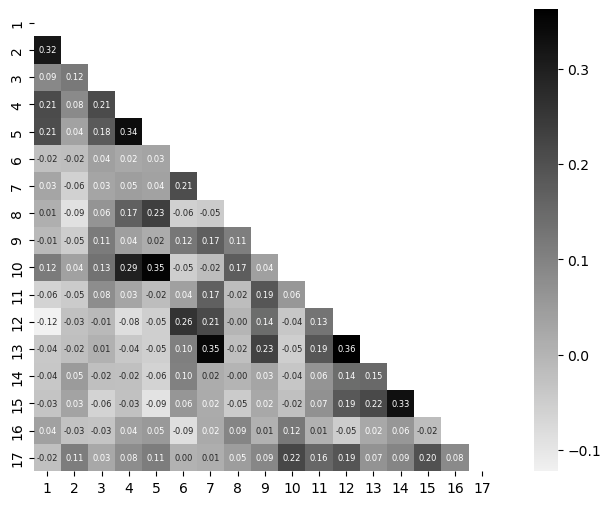

In [63]:
# SR data: Between SDG dependencies

# calculate correlations
corr = sr_data[class_names].corr()

# Create a mask to hide upper right triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create black to white color transition
cmap = sns.light_palette("black", as_cmap=True)

# plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, square=True, annot_kws={"size":6}, fmt='.2f')
plt.savefig(f'data/plot_images/correlation_matrix.png',bbox_inches='tight')
plt.show();

In [96]:
frequencies_1 = text_train_1[text_train_1['original'] ==1][class_names].sum(axis=0).to_frame(name='Frequency')
ratio_1 = frequencies_1.min() / frequencies_1.max()
print('Original Balance ratio: ', ratio_1)

frequencies_2 = text_train_2[text_train_2['original'] ==1][class_names].sum(axis=0).to_frame(name='Frequency')
ratio_2 = frequencies_2.min() / frequencies_2.max()
print('Original Balance ratio: ', ratio_2)

Original Balance ratio:  Frequency    0.44186
dtype: float64
Original Balance ratio:  Frequency    0.184818
dtype: float64
Frequency    56.0
dtype: float64


In [64]:
# Metrics for RQ 2
metrics_2 = pd.DataFrame(columns=['dataset', 'model', 'precision', 'recall', 'f1-score'])

for model in ['word2vec_svm', 'glove_svm', 'bert', 'roberta', 'xlnet', 'gpt2']: # 'glove_svm', 

    # load predictions
    results = pd.read_csv(f'data/text_test_results/{model}.csv')
    targets = [json.loads(x) for x in results['target']]
    preds = [json.loads(x) for x in results[f'pred_2']]

    # calculate metrics
    p_r_f = precision_recall_fscore_support(targets, preds, average='micro')

    # add metrics to dataframe
    metrics_2 = metrics_2.append({'dataset': 2, 'model': model, 'Model': model_name_dict[model], 'precision': round(p_r_f[0],3) , 'recall': round(p_r_f[1],3), 'f1-score': round(p_r_f[2],3)}, ignore_index=True)

metrics_2

,dataset,model,precision,recall,f1-score,Model
0,2,word2vec_svm,0.246,0.693,0.363,Word2Vec SVM
1,2,glove_svm,0.263,0.476,0.339,GloVe SVM
2,2,bert,0.487,0.565,0.523,BERT
3,2,roberta,0.530,0.647,0.582,RoBERTa
4,2,xlnet,0.486,0.605,0.539,XLNet
5,2,gpt2,0.389,0.515,0.443,GPT-2


In [65]:
# Metrics for RQ 1

metrics_1 = pd.DataFrame(columns=['dataset', 'model', 'precision', 'recall', 'f1-score'])

for model in ['word2vec_svm', 'bert']:

    # load predictions
    results = pd.read_csv(f'data/text_test_results/{model}.csv')
    targets = [json.loads(x) for x in results['target']]
    
    for data_number in [1,2]:
        preds = [json.loads(x) for x in results[f'pred_{data_number}']]

        # calculate metrics
        p_r_f = precision_recall_fscore_support(targets, preds, average='micro')

        # add metrics to dataframe
        metrics_1 = metrics_1.append({'dataset': str(data_number), 'model': model, 'Model': model_name_dict[model], 'precision': round(p_r_f[0],3) , 'recall': round(p_r_f[1],3), 'f1-score': round(p_r_f[2],3)}, ignore_index=True)
# 'Training data-set '+  
metrics_1

,dataset,model,precision,recall,f1-score,Model
0,1,word2vec_svm,0.204,0.780,0.323,Word2Vec SVM
1,2,word2vec_svm,0.246,0.693,0.363,Word2Vec SVM
2,1,bert,0.412,0.542,0.468,BERT
3,2,bert,0.487,0.565,0.523,BERT


In [66]:
model = 'word2vec_svm'
# load predictions
results = pd.read_csv(f'data/text_test_results/{model}.csv')
targets = [json.loads(x) for x in results['target']]

preds = [json.loads(x) for x in results[f'pred_2']]

# calculate metrics
p_r_f = precision_recall_fscore_support(targets, preds, average='micro')
print(p_r_f)

f1 = f1_score(targets, preds, average='micro')
print(f1)

(0.24617903930131005, 0.6927803379416283, 0.36327023761578736, None)
0.36327023761578736


In [67]:
data = 2

# metrics_1['dataset_desc'] = np.where(metrics_1['dataset'] == 1, '1 - scientific text', '2 - scientific and sr text')

fig = px.bar(
    metrics_1, 
    x='dataset', 
    y='f1-score',
    color='model',
    barmode="group",
    color_discrete_map={
        'word2vec_svm': 'gray',
        'bert': "lightgray",
    },
    text_auto=True
).update_layout(
    # title='Q1 - Dataset Comparison',
    xaxis_title='Train data-set',
    yaxis_title='F1 Score',
    plot_bgcolor='whitesmoke',
    # legend=dict(
    #     yanchor="top",
    #     y=0.97,
    #     xanchor="left",
    #     x=0.01
    # ),
    legend_title='Model'
)
pio.write_image(fig, "data/plot_images/q1_f1s.png", scale=3, width=900, height=400)
fig.show()

In [68]:
data = 2

fig = px.bar(
    metrics_2[metrics_2['dataset'] == data], 
    x='Model', 
    y=['precision','recall','f1-score'],
    barmode="group",
    color_discrete_map={
    # 'precision': 'gray',
    # 'recall': "#9e9e9e",
    # 'f1-score': "black",   
    'precision': "#9e9e9e",
    'recall': "lightgray",
    'f1-score': 'gray',     
    },
).update_layout(
    # title='Q2 - Model Comparison',
    xaxis_title='Model',
    yaxis_title='Metric Value',
    legend_title='Metric',
    plot_bgcolor='whitesmoke',
    # legend=dict(
    #     yanchor="top",
    #     y=0.97,
    #     xanchor="right",
    #     x=0.01
    # ),
)

pio.write_image(fig, "data/plot_images/q2_f1s.png", scale=3, width=900, height=400)
fig.show()

In [69]:
best_model = metrics_2[metrics_2['f1-score'] == metrics_2['f1-score'].max()]['model']
best_model = best_model.iloc[0]
results = pd.read_csv(f'data/text_test_results/{best_model}.csv')
targets = [json.loads(x) for x in results['target']]
preds = [json.loads(x) for x in results[f'pred_{data}']]

class_descriptions = class_names# [sdg[0]+ ': '+ sdg[1] for sdg in sdg_short_description.items()]

report = classification_report(targets, preds, target_names=class_descriptions, output_dict=True)

df_report = pd.DataFrame(report).transpose()

df_report = df_report[['precision','recall','f1-score', 'support']][:17]
df_report['sdg'] = df_report.index

# calculate label frequencies and scale them to range 0-60
frequ_2 = text_train_2[text_train_2['original']==1][class_names].sum(axis=0).to_frame(name='frequency')
frequ_2['ratio'] = frequ_2['frequency'] * 0.80 / max(frequ_2['frequency'])
frequ_2['sdg'] = frequ_2.index

fig = px.bar(df_report, 
    x='sdg', 
    y=['precision','recall','f1-score'], 
    barmode="group",
    color_discrete_map={
        'precision': "#9e9e9e",
        'recall': "lightgray",
        'f1-score': 'gray',   
    }
)
fig.add_trace(go.Scatter(x= df_report['sdg'], y=frequ_2['ratio'], mode = 'lines', name="frequency", line_color="black"),secondary_y=False)
fig.update_layout(
    # title='Best Model '+ model_name_dict[best_model] + ' - F1 Scores within labels',
    xaxis_title='SDG',
    yaxis_title='Metric Value',
    plot_bgcolor='whitesmoke',
    xaxis_tickmode='linear',
    legend_title='Metric'
)
pio.write_image(fig, "data/plot_images/best_f1_within_labels.png", scale=3, width=900, height=400)
fig.show()

In [70]:
df_report

,precision,recall,f1-score,support,sdg
1,0.142857,0.750000,0.240000,8.0,1
2,0.400000,0.333333,0.363636,6.0,2
3,0.588235,0.754717,0.661157,53.0,3
4,0.543478,0.675676,0.602410,37.0,4
5,0.612245,0.666667,0.638298,45.0,5
6,0.615385,0.307692,0.410256,26.0,6
7,0.474576,0.777778,0.589474,36.0,7
8,0.660550,0.808989,0.727273,89.0,8
9,0.555556,0.609756,0.581395,41.0,9
10,0.312500,0.606061,0.412371,33.0,10


In [72]:
# Overview Table
overview = pd.DataFrame()

scholar_data = text_train_1[(text_train_1['data_origin'] == 'paper abstract')]
wiki_data = text_train_1[(text_train_1['data_origin'] == 'wikipedia article')]
un_data = text_train_1[(text_train_1['data_origin'] == 'un website')]

total = pd.concat([text_train_1[text_train_1['data_ml'] == 'train'], sr_data], ignore_index=True, axis=0)

datasets = [un_data, scholar_data, wiki_data, sr_data, total, text_train_1, text_train_2, text_test]
dataset_names = ['UN data', 'Paper data', 'Wikipedia data', 'SR data', 'Total', 'trainingset I', 'trainingset II', 'testingset']

for i, dataset in enumerate(datasets):
    
    amount_samples = len(dataset)
    avg_n_tokens = dataset['text'].apply(lambda x: len(str(x).split())).mean()
    avg_n_sdgs = dataset[class_names].sum(axis=1).mean()

    overview = overview.append({
        'Dataset': dataset_names[i], 
        '# Samples': amount_samples, 
        'Avg # Tokens per sample': avg_n_tokens, 
        'Avg # SDGs per sample': avg_n_sdgs
        },ignore_index=True)


overview[['Dataset', '# Samples', 'Avg # Tokens per sample', 'Avg # SDGs per sample']]

,Dataset,# Samples,Avg # Tokens per sample,Avg # SDGs per sample
0,UN data,367.0,60.215259,1.000000
1,Paper data,227.0,150.722467,1.000000
2,Wikipedia data,401.0,66.276808,0.000000
3,SR data,1052.0,282.093156,3.106464
4,Total,2047.0,185.467513,1.886663
5,trainingset I,995.0,83.306533,0.596985
6,trainingset II,3057.0,187.945044,2.575728
7,testingset,214.0,271.051402,3.042056


In [80]:
# Overview History Transformers
data = 2
ov_model = 'xlnet'

In [92]:
overview = pd.DataFrame()

def prep_run(run):
    row = run['parameters']
    idx = np.argmax(run['val_f1'])
    row['f1'] = run['val_f1'][idx ]
    row['val_loss'] = run['val_loss'][idx]
    row['train_loss'] = run['train_loss'][idx]
    row['thresholds'] = run['threshold'][idx]
    return row

history = transformer_histories[f'{data}_{ov_model}']

for balance_opt in ['original', 'ratio_0.25', 'ratio_0.50', 'ratio_0.75', 'ratio_0.90']:
    run = history['modification']['balancing'][balance_opt]

    overview = overview.append(prep_run(run), ignore_index=True)


run = history['modification']['further_pretraining']
overview = overview.append(prep_run(run), ignore_index=True)

for run in history['fine_tuning']:
    overview = overview.append(prep_run(run), ignore_index=True)

run = history['final']
overview = overview.append(prep_run(run), ignore_index=True)

overview['lr'] = overview['lr'].apply(lambda x: str(int(x*100000))+'e-05')
overview['epochs'] = overview['epochs'].apply(lambda x: str(int(x)))
overview['batch_size'] = overview['batch_size'].apply(lambda x: str(int(x)))


overview['further_pretraining'] = np.where(overview['further_pretraining'] == 1, 'true', 'false')

overview = overview[[
    'epochs',
    'balancing',
    'further_pretraining',
    'batch_size',
    'lr',
    'warmup_ratio',
    'weight_decay',
    'with_weight',
    'f1',
]]

overview = overview.rename(columns={
    'epochs': 'Epochs', 
    'balancing': 'Balancing',
    'further_pretraining': 'Further Pre-training',
    'batch_size': 'Batch Size',
    'lr': 'Learning Rate',
    'warmup_ratio': 'Warm-up Ratio',
    'weight_decay': 'Weight Decay',
    'with_weight': 'Loss weighted',
    'f1': 'Val F1 Score',
})

overview = overview.round(3)
overview

,Epochs,Balancing,Further Pre-training,Batch Size,Learning Rate,Warm-up Ratio,Weight Decay,Loss weighted,Val F1 Score
0,10,original,false,32,3e-05,0.00,0.00,0.0,0.517
1,10,ratio_0.25,false,32,3e-05,0.00,0.00,0.0,0.548
2,10,ratio_0.50,false,32,3e-05,0.00,0.00,0.0,0.542
3,10,ratio_0.75,false,32,3e-05,0.00,0.00,0.0,0.559
4,10,ratio_0.90,false,32,3e-05,0.00,0.00,0.0,0.533
5,10,ratio_0.75,true,32,3e-05,0.00,0.00,0.0,0.548
6,10,ratio_0.75,false,16,1e-05,0.06,0.01,0.0,0.564
7,10,ratio_0.75,false,16,3e-05,0.10,0.01,0.0,0.570
8,10,ratio_0.75,false,16,1e-05,0.06,0.10,1.0,0.559
9,10,ratio_0.75,false,16,1e-05,0.10,0.01,1.0,0.573


In [88]:
['-']*3

['-', '-', '-']

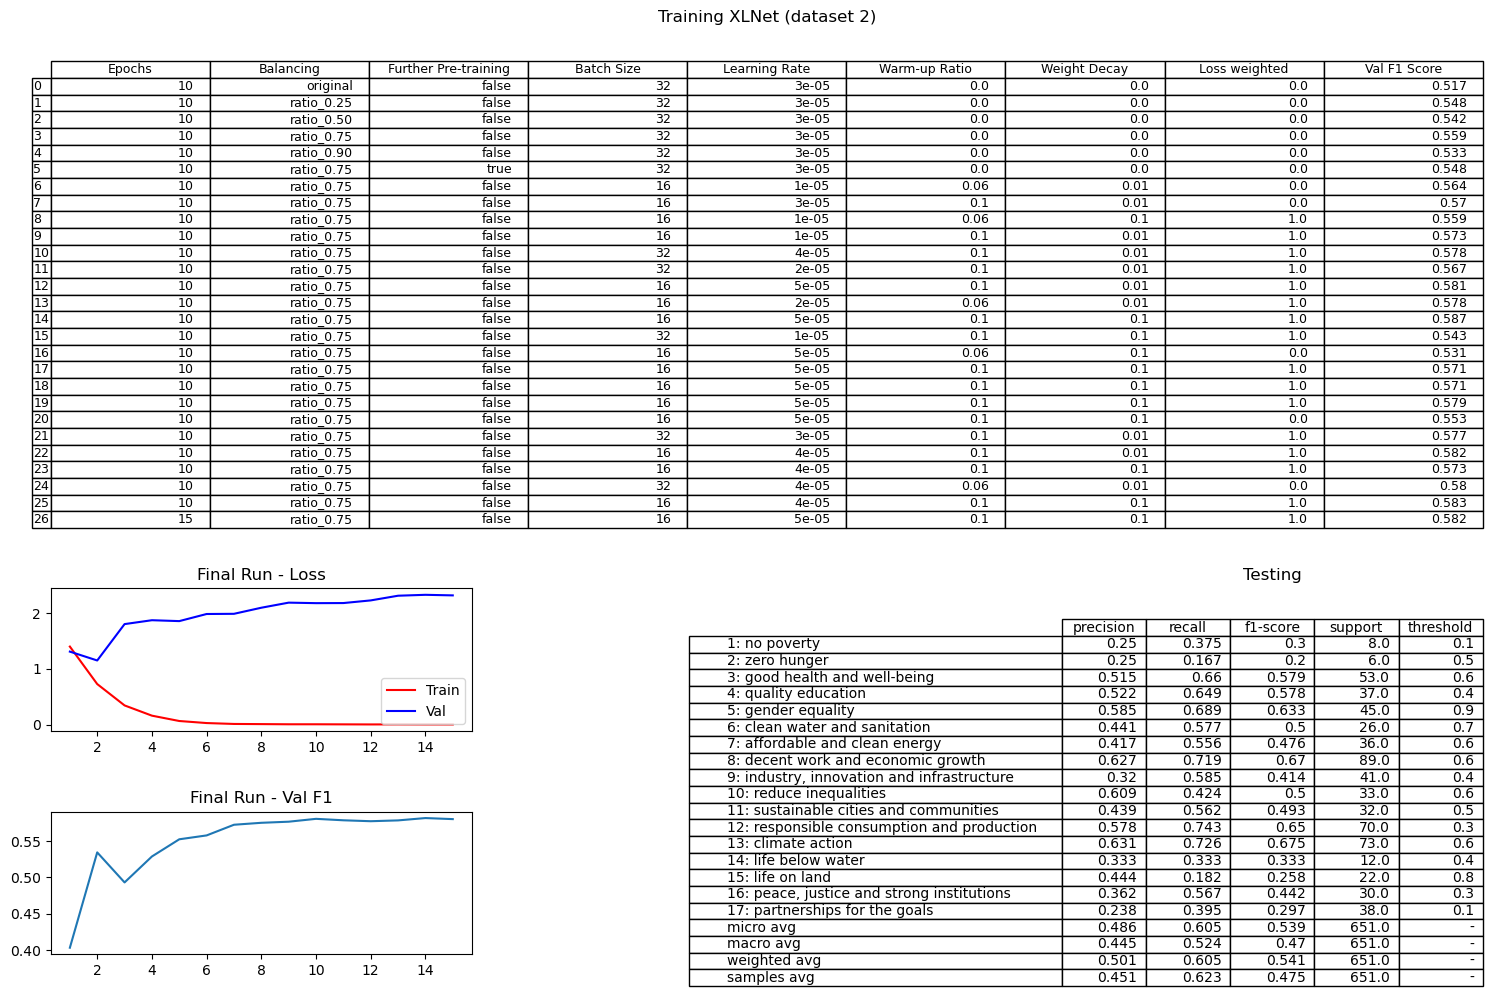

In [93]:
# get history
final = transformer_histories[f'{data}_{ov_model}']['final']
df = pd.DataFrame({'val_f1': final['val_f1'], 'train_loss': final['train_loss'], 'val_loss': final['val_loss'], 'epoch': range(1,len(final['val_f1'])+1)})

results = pd.read_csv(f'data/text_test_results/{ov_model}.csv')
targets = [json.loads(x) for x in results['target']]
preds = [json.loads(x) for x in results[f'pred_{data}']]

class_descriptions = [sdg[0]+ ': '+ sdg[1] for sdg in sdg_short_description.items()]
report = classification_report(targets, preds, target_names=class_descriptions, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(3)   # .drop(columns=['support'])
df_report.index.name = 'Testing'

# add thresholds
thresholds = prep_run(final)['thresholds']
thresholds.extend(['-']*4)
df_report['threshold'] = thresholds

# create objects
fig = plt.figure(figsize=(25,12))

# create sub plots as grid
gs = fig.add_gridspec(25, 4)
ax1 = fig.add_subplot(gs[15:19, 1])
ax2 = fig.add_subplot(gs[21:25, 1])
ax3 = fig.add_subplot(gs[0, 1:], frame_on=False)
ax4 = fig.add_subplot(gs[15, 3], frame_on=False)

ax1.plot(df['epoch'],df['train_loss'],c='r', label="Train")
ax1.plot(df['epoch'],df['val_loss'], c='b', label="Val")
ax1.set_title('Final Run - Loss')
ax1.legend(loc="best")

ax2.plot(df['epoch'],df['val_f1'])
ax2.set_title('Final Run - Val F1')


ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title(f'Training {model_name_dict[ov_model]} (dataset {data})')
table(ax3, overview)

ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)
ax4.set_title('Testing')
table(ax4, df_report)

plt.savefig(f'data/plot_images/{data}_{ov_model}',bbox_inches='tight')

# depict illustration
plt.show()

In [68]:
svm_model = 'word2vec_svm'
data = 2

In [79]:
overview = pd.DataFrame()

def prep_run(run):
    row = run['parameters']
    idx = np.argmax(run['val_f1'])
    row['f1'] = run['val_f1'][idx ]
    row['val_loss'] = run['val_loss'][idx]
    row['train_loss'] = run['train_loss'][idx]
    return row

history = svm_histories[f'{data}_{svm_model}']

overview = pd.DataFrame(columns=['scaling', 'balancing', 'feature selection', 'combination', 'c', 'loss', 'with_weight', 'f1'])

for scaling_opt in ['no_scaling', 'StandardScaler', 'RobustScaler']:
    f1 = history['scaling'][scaling_opt]
    overview = overview.append({
        'scaling': scaling_opt, 
        'f1': f1, 
        'balancing': 'original', 
        'feature selection': 'no_pca', 
        'combination': 'one_vs_rest',
        'c': 1.0,
        'loss': 'squared_hinge',
        'with_weight': False,
    } , ignore_index=True)
scale_best = max(history['scaling'], key=history['scaling'].get)

for balance_opt in ['original', 'ratio_0.25', 'ratio_0.50', 'ratio_0.75']:
    f1 = history['balancing'][balance_opt]
    overview = overview.append({
        'scaling': scale_best,
        'balancing': balance_opt, 
        'f1': f1,
        'feature selection': 'no_pca', 
        'combination': 'one_vs_rest',
        'c': 1.0,
        'loss': 'squared_hinge',
        'with_weight': False,
    } , ignore_index=True)
balance_best = max(history['balancing'], key=history['balancing'].get)

for pca_opt in ['no_pca', '1', '0.75', '0.5']:
    f1 = history['feature_selection'][pca_opt]
    overview = overview.append({
        'scaling': scale_best,
        'balancing': balance_best, 
        'f1': f1,
        'feature selection': pca_opt,
        'combination': 'one_vs_rest',
        'c': 1.0,
        'loss': 'squared_hinge',
        'with_weight': False,   
    } , ignore_index=True)
pca_best = max(history['feature_selection'], key=history['feature_selection'].get)

for comb_opt in ['one_vs_rest', 'classifier_chain']:
    f1 = history['combination'][comb_opt]
    overview = overview.append({
        'scaling': scale_best,
        'balancing': balance_best, 
        'f1': f1,
        'feature selection': pca_best,
        'combination': comb_opt,
        'c': 1.0,
        'loss': 'squared_hinge',
        'with_weight': False,  
    } , ignore_index=True)
comb_best = max(history['combination'], key=history['combination'].get)

for run in history['fine_tuning']:
    run['scaling'] = scale_best
    run['balancing'] = balance_best
    run['feature selection'] = pca_best
    run['combination'] = comb_best    
    overview = overview.append(run , ignore_index=True)

run = history['final']
run['scaling'] = scale_best
run['balancing'] = balance_best
run['feature selection'] = pca_best
run['combination'] = comb_best 
overview = overview.append(run, ignore_index=True)


overview['f1'] = overview['f1'].round(4)
overview = overview.rename(columns={
    'scaling': 'Scaling', 
    'balancing': 'Balancing',
    'feature selection': 'Feature Selection',
    'combination': 'Problem Transformation',
    'loss': 'Loss Function',   
    'c': 'C Value',
    'with_weight': 'C Weighted',
    'f1': 'Val F1',
})

overview

NameError: name 'svm_model' is not defined

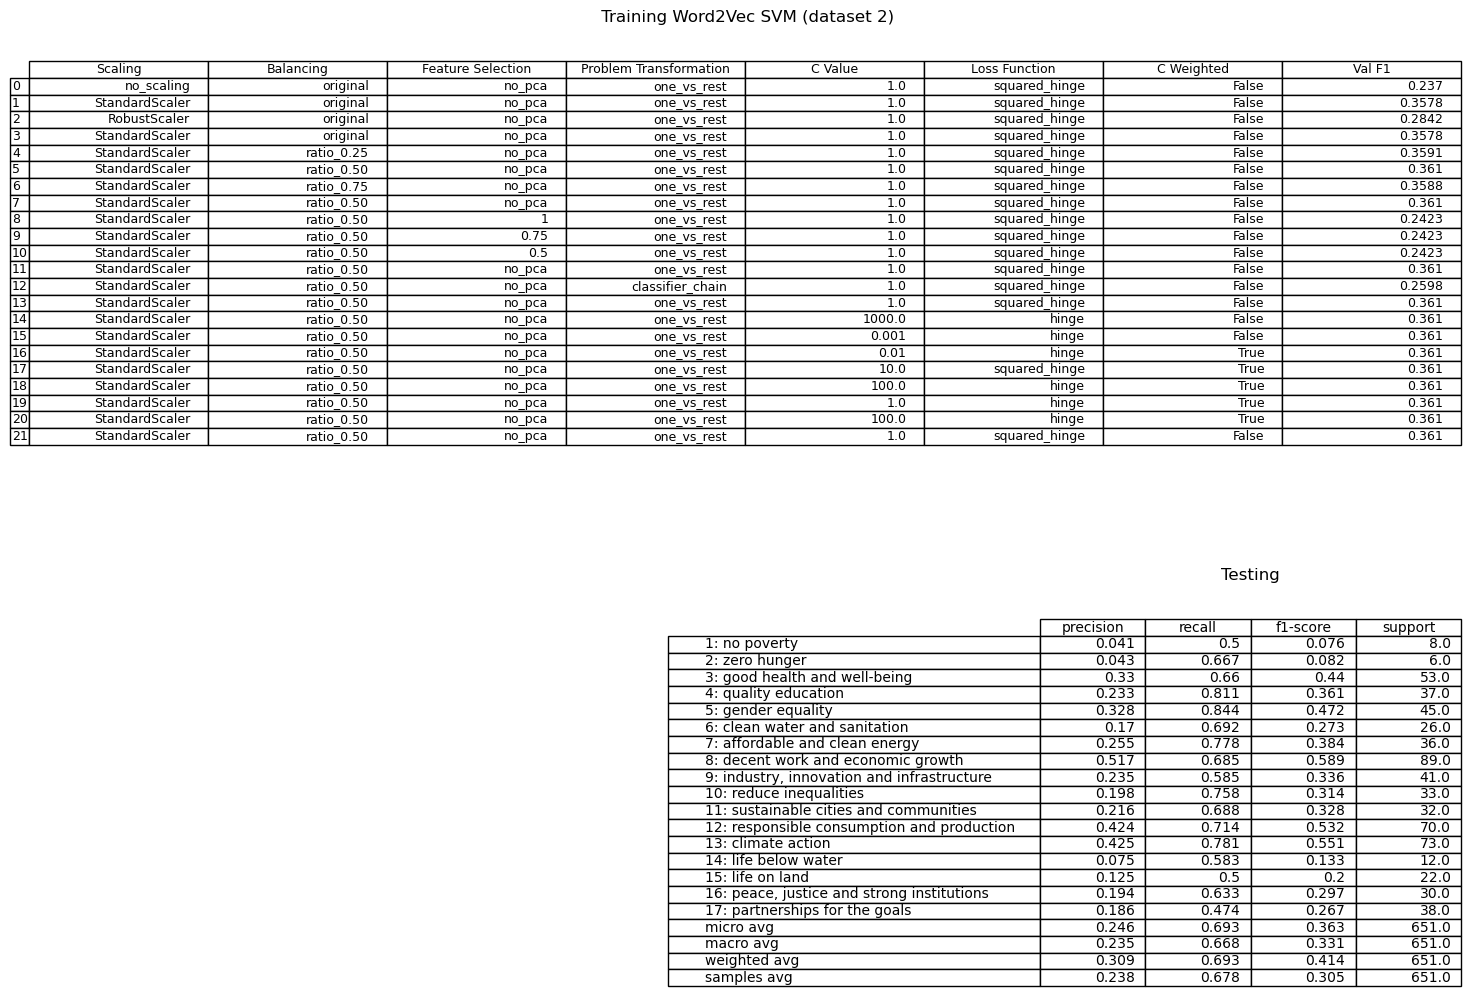

In [70]:
results = pd.read_csv(f'data/text_test_results/{svm_model}.csv')
targets = [json.loads(x) for x in results['target']]
preds = [json.loads(x) for x in results[f'pred_{data}']]

class_descriptions = [sdg[0]+ ': '+ sdg[1] for sdg in sdg_short_description.items()]
report = classification_report(targets, preds, target_names=class_descriptions, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(3)
df_report.index.name = 'Testing'

# create objects
fig = plt.figure(figsize=(25,12))

# create sub plots as grid
gs = fig.add_gridspec(25, 4)
ax3 = fig.add_subplot(gs[0, 1:], frame_on=False)
ax4 = fig.add_subplot(gs[15, 3], frame_on=False)

ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title(f' Training {model_name_dict[svm_model]} (dataset {data})')
table(ax3, overview)

ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)
ax4.set_title('Testing')
table(ax4, df_report)

plt.savefig(f'data/plot_images/{data}_{svm_model}',bbox_inches='tight')

# depict illustration
plt.show()

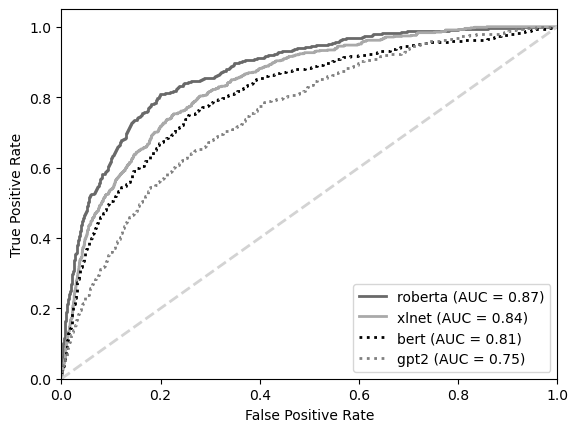

In [71]:
from sklearn.metrics import roc_curve, auc

models = ['roberta', 'xlnet', 'bert', 'gpt2']
plt.figure()
lw = 2
colors = ["dimgray","darkgray" , "black", "gray"]
line_styles = [None, None, ":", ":"]
outs_per_model = []

for i, model in enumerate(models): 
    results = pd.read_csv(f'data/text_test_results/{model}.csv')
    targets = [json.loads(x) for x in results['target']]
    outs = [json.loads(x) for x in results[f'outs_{data}']]
    targets = np.array(targets).flatten()
    outs = np.array(outs).flatten()

    fpr, tpr, thresholds = roc_curve(targets, outs)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        color=colors[i],
        lw=lw,
        label="{0} (AUC = {1:0.2f})".format(model, roc_auc),
        linestyle=line_styles[i],
    )

plt.plot([0, 1], [0, 1], color="lightgray", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curves")
plt.legend(loc="lower right")

plt.savefig(f'data/plot_images/roc_curves.png',bbox_inches='tight')

plt.show()

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

n_words_per_sdg = 15
tfidf_df = pd.DataFrame(columns=['si_data', 'sr_data'])
# word clouds -> 
sdg = 1
si_data = text_train_1[(text_train_1['original'] == 1)].reset_index(drop=True)
si_data = text_preprocessing(si_data, lemmantization=False, stop_words=True, lower_case=False)
sr_data = sr_data.reset_index(drop=True) # [sr_data[class_names].sum(axis=1) == 1]
sr_data = text_preprocessing(sr_data, lemmantization=False, stop_words=True, lower_case=False)
# X_sr = vectorizer.fit_transform(sr_data['text'])

terms_dict = {0: [], 1:[]}
for i, text_data in enumerate([si_data, sr_data]):
    # calculate TF-IDF values
    vectorizer = TfidfVectorizer()
    X_si = vectorizer.fit_transform(text_data['text'])

    # turn sparse matrix to dataframe with words as columns
    list_dense = X_si.todense().tolist()
    data_term_frequencies = pd.DataFrame(list_dense, columns=vectorizer.get_feature_names())

    for sdg in class_names:
    # get sdg related text and return the 10 most important and most common words
        sdg_term_frequencies = data_term_frequencies[text_data[str(sdg)] == 1]
        terms = sdg_term_frequencies.T.sum(axis=1).sort_values(ascending=False)[:n_words_per_sdg].index.tolist()
        terms_dict[i].append(terms)

# terms_dict
df = pd.DataFrame(terms_dict).rename(columns={0: 'sientific', 1: 'sustainability report'})
df.index = df.index + 1


In [103]:
# turn table to text for latex table
for idx, row in df.iterrows():
    print(str(idx) + ' & ' + str(row['sientific']).replace("'","").strip('[]') + ' & ' + str(row['sustainability report']).replace("'","").strip('[]') + ' \\\\  \\hline')



1 & poverty, proportion, poor, living, disaster, reduction, national, strategies, population, vulnerable, persons, people, sex, line, women & de, employees, igt, we, sdgs, diversity, communities, by, rbi, education, development, local, supporting, support, women \\  \hline
2 & food, agricultural, hunger, security, development, agriculture, insecurity, rice, production, scale, sustainable, genetic, the, access, including & food, we, nutrition, local, communities, community, farmers, hunger, sustainable, our, people, quality, by, development, employees \\  \hline
3 & health, mortality, deaths, countries, diseases, medicines, vaccines, by, global, tobacco, development, alcohol, per, national, communicable & health, we, safety, employees, our, development, the, sustainable, global, people, sustainability, business, communities, wellbeing, human \\  \hline
4 & education, development, learning, sustainable, sdg, by, educational, quality, youth, teachers, adults, skills, ensure, vocational, i

In [74]:

# print(X_si.shape)
# top_n = 5
# print('tf_idf scores: \n', sorted(list(zip(vectorizer.get_feature_names(), 
#                                              X_si.sum(0).getA1())), 
#                                  key=lambda x: x[1], reverse=True)[:top_n])


# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [sdg_colors[sdg], "white"])
# sdg_term_frequencies = data_term_frequencies[sdg_data[str(sdg)] == 1]
# wordcloud = WordCloud(background_color="white", max_words=50,colormap = cmap).generate_from_frequencies(sdg_term_frequencies.T.sum(axis=1)) #white
# plt.figure( figsize=(20,5) )
# plt.imshow(wordcloud, interpolation="bilinear")
# #plt.title("SDG: "+ str(sdg) + " - "+ sdg_short_description[str(sdg)])
# plt.axis("off")
# plt.show()